In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [73]:
print('Successfully Load Libraries')

Successfully Load Libraries


In [74]:
# read data and remove unnecessary column
df = pd.read_csv("/content/Advertising.csv")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

print('Successfully Read Data')

Successfully Read Data


In [75]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [76]:
df.tail()

,TV,Radio,Newspaper,Sales
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5
199,232.1,8.6,8.7,13.4


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [78]:
df.isnull().sum()

,0
TV,0
Radio,0
Newspaper,0
Sales,0


In [79]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [80]:
df.shape

(200, 4)

In [81]:
df.columns

Index(['TV', 'Radio', 'Newspaper', 'Sales'], dtype='object')

In [82]:
print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


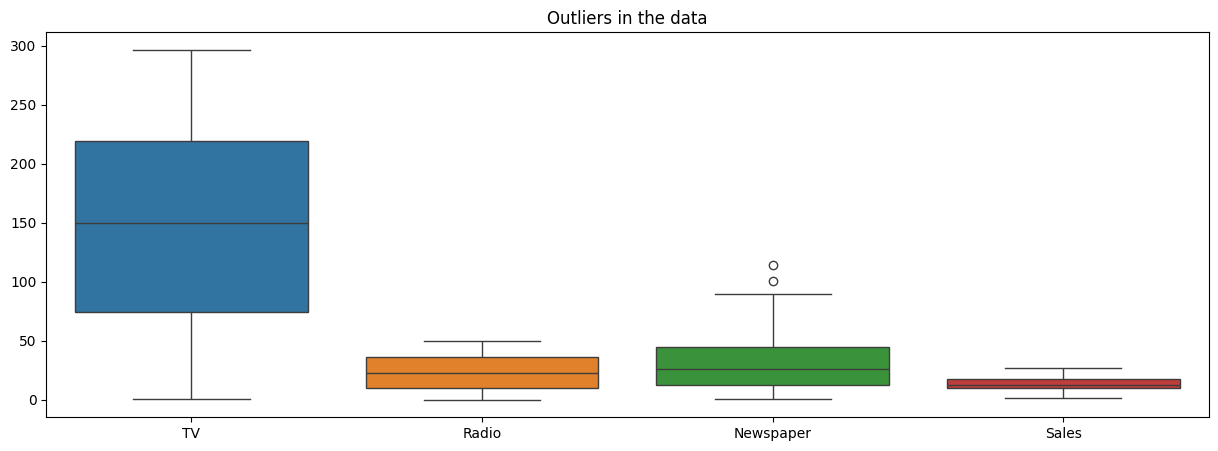

In [83]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df)
plt.title("Outliers in the data")
plt.show()

In [84]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df[(df["Newspaper"] > (Q3["Newspaper"] + 1.5 * IQR["Newspaper"]))]

,TV,Radio,Newspaper,Sales
16,67.8,36.6,114.0,12.5
101,296.4,36.3,100.9,23.8


After removing outliers:


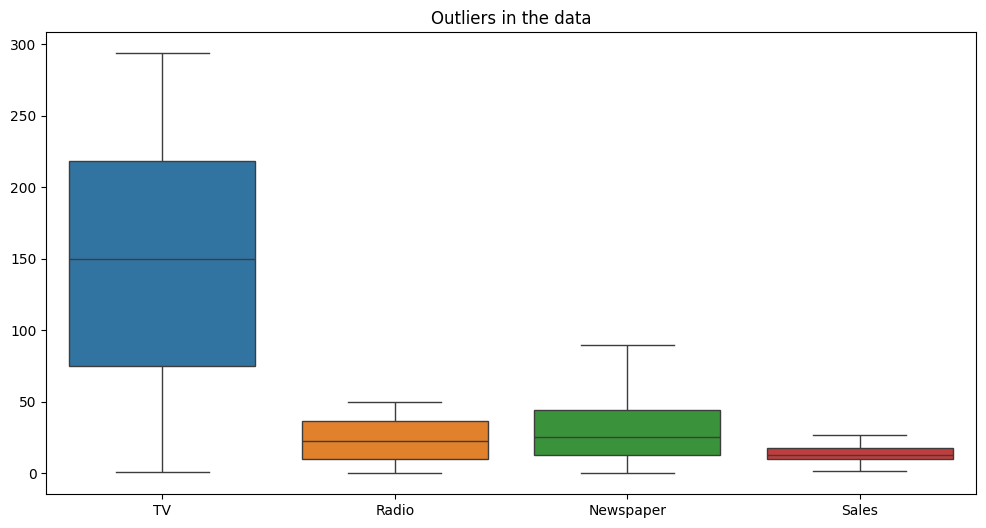

In [85]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print('After removing outliers:')

# check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Outliers in the data")
plt.show()

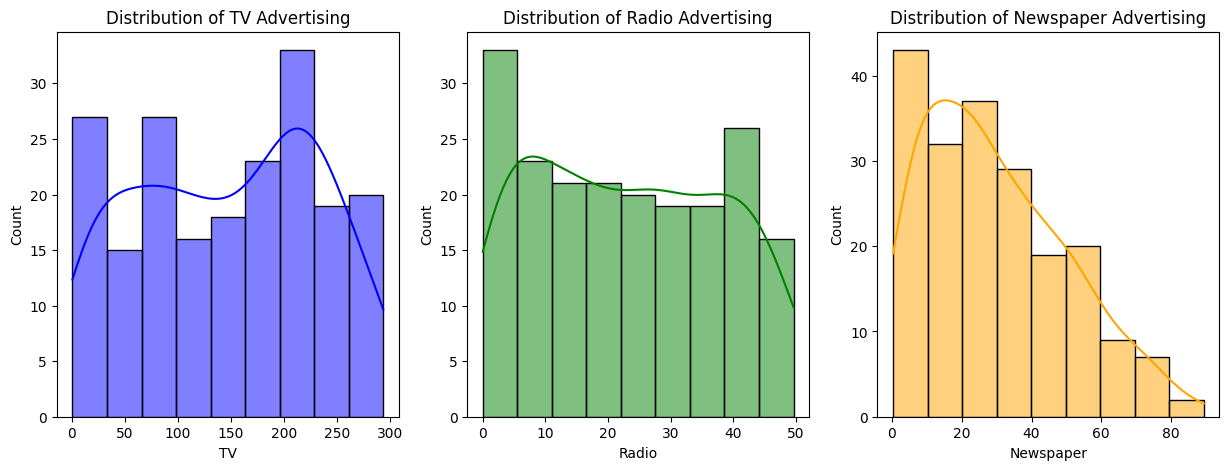

In [86]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['TV'], kde=True, color='blue')
plt.title('Distribution of TV Advertising')

plt.subplot(1, 3, 2)
sns.histplot(df['Radio'], kde=True, color='green')
plt.title('Distribution of Radio Advertising')

plt.subplot(1, 3, 3)
sns.histplot(df['Newspaper'], kde=True, color='orange')
plt.title('Distribution of Newspaper Advertising')

plt.show()

In [87]:
print("Skewness in TV column:", df["TV"].skew())
print("Skewness in Radio column:", df["Radio"].skew())
print("Skewness in Newspaper column:", df["Newspaper"].skew())

# Interpretation of skewness values
print("\nInterpretation of Skewness : ")
print("Skewness > 0: Right skewed distribution (positive skew)")
print("Skewness = 0: Symmetrical distribution")
print("Skewness < 0: Left skewed distribution (negative skew)")

Skewness in TV column: -0.08233208466403653
Skewness in Radio column: 0.11484208726730326
Skewness in Newspaper column: 0.650111551724088

Interpretation of Skewness : 
Skewness > 0: Right skewed distribution (positive skew)
Skewness = 0: Symmetrical distribution
Skewness < 0: Left skewed distribution (negative skew)


In [88]:
print("Kurtosis in TV column:", df["TV"].kurtosis())
print("Kurtosis in Radio column:", df["Radio"].kurtosis())
print("Kurtosis in Newspaper column:", df["Newspaper"].kurtosis())
print("Kurtosis in Sales column:", df["Sales"].kurtosis())

# Interpretation of kurtosis values
print("\nInterpretation of Kurtosis:")
print("Kurtosis > 3: Leptokurtic distribution (heavy tails)")
print("Kurtosis = 3: Mesokurtic distribution (normal distribution)")
print("Kurtosis < 3: Platykurtic distribution (light tails)")

Kurtosis in TV column: -1.2265360653240356
Kurtosis in Radio column: -1.2523978830692584
Kurtosis in Newspaper column: -0.33298368090117947
Kurtosis in Sales column: -0.39038261264334295

Interpretation of Kurtosis:
Kurtosis > 3: Leptokurtic distribution (heavy tails)
Kurtosis = 3: Mesokurtic distribution (normal distribution)
Kurtosis < 3: Platykurtic distribution (light tails)


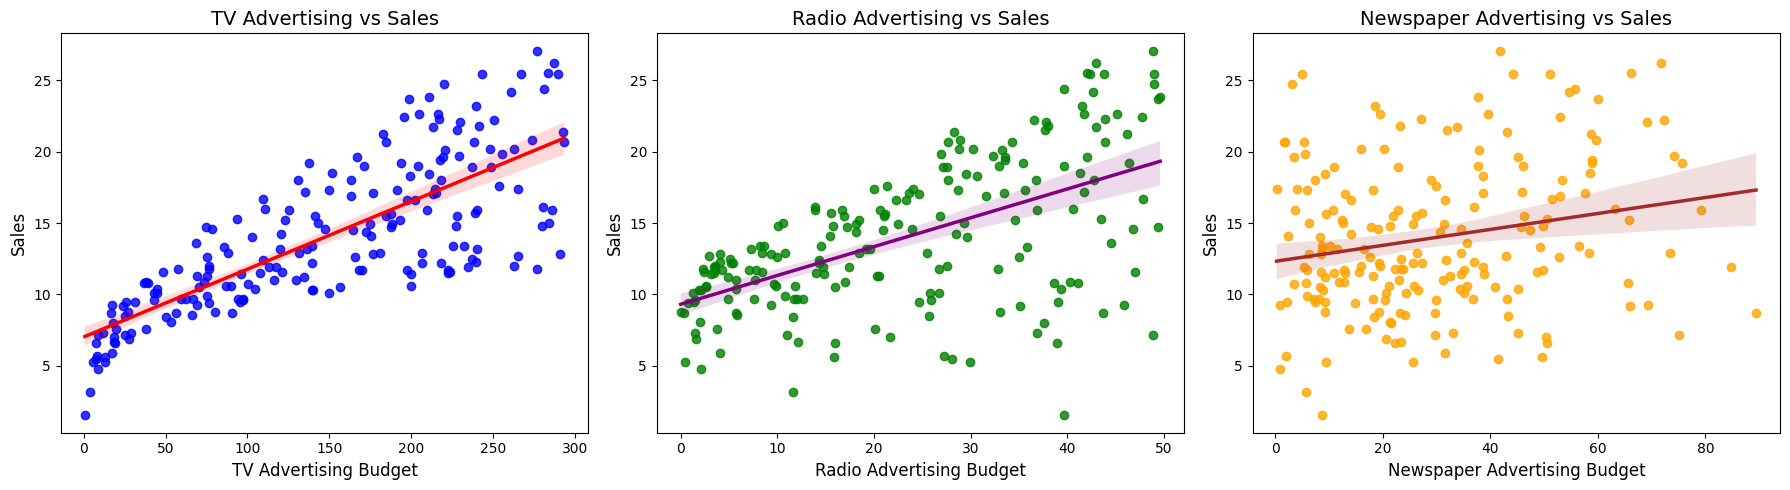

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# LM plot for TV vs Sales
sns.regplot(x='TV', y='Sales', data=df,
            scatter_kws={'color': 'blue', 'alpha': 0.8},
            line_kws={'color': 'red', 'linewidth': 2.5},
            ax=axes[0])
axes[0].set_title('TV Advertising vs Sales', fontsize=14)
axes[0].set_xlabel('TV Advertising Budget', fontsize=12)
axes[0].set_ylabel('Sales', fontsize=12)

# LM plot for Radio vs Sales
sns.regplot(x='Radio', y='Sales', data=df,
            scatter_kws={'color': 'green', 'alpha': 0.8},
            line_kws={'color': 'purple', 'linewidth': 2.5},
            ax=axes[1])
axes[1].set_title('Radio Advertising vs Sales', fontsize=14)
axes[1].set_xlabel('Radio Advertising Budget', fontsize=12)
axes[1].set_ylabel('Sales', fontsize=12)
sns.regplot(x='Newspaper', y='Sales', data=df,
            scatter_kws={'color': 'orange', 'alpha': 0.8},
            line_kws={'color': 'brown', 'linewidth': 2.5},
            ax=axes[2])
axes[2].set_title('Newspaper Advertising vs Sales', fontsize=14)
axes[2].set_xlabel('Newspaper Advertising Budget', fontsize=12)
axes[2].set_ylabel('Sales', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


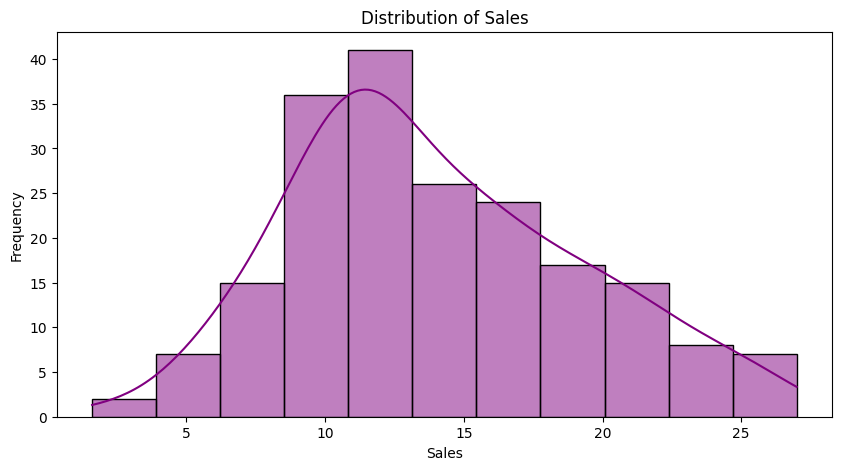

In [90]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Sales'], kde=True, color='purple')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [91]:
sales_skewness = df['Sales'].skew()
sales_kurtosis = df['Sales'].kurtosis()

print(f"Skewness of Sales: {sales_skewness}")
print(f"Kurtosis of Sales: {sales_kurtosis}")

Skewness of Sales: 0.4071300154120368
Kurtosis of Sales: -0.39038261264334295


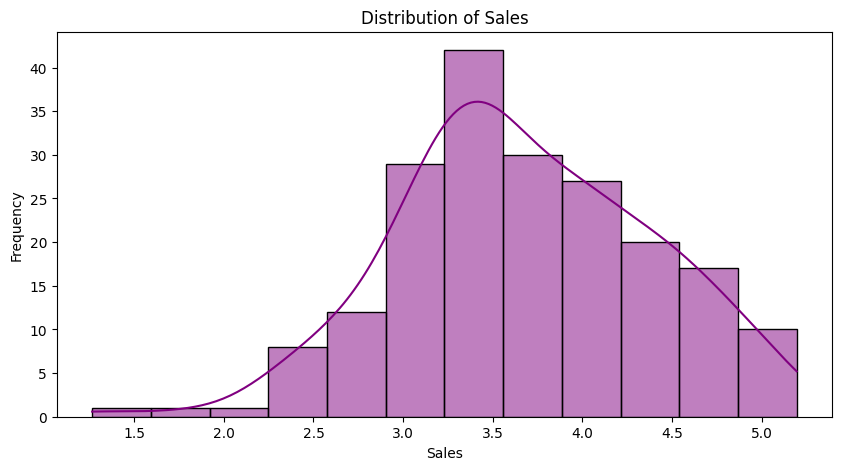

In [92]:
df['Sales']= np.sqrt(df['Sales']).round(4)

# check distribution after applying square root transformation
plt.figure(figsize=(10, 5))
sns.histplot(df['Sales'], kde=True, color='purple')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()



In [93]:
sales_skewness = df['Sales'].skew()
sales_kurtosis = df['Sales'].kurtosis()

print('After applying square root transformation \n')
print(f"Skewness of Sales: {sales_skewness}")
print(f"Kurtosis of Sales: {sales_kurtosis}")

After applying square root transformation 

Skewness of Sales: -0.10228049018046029
Kurtosis of Sales: -0.042391862218277954


In [94]:
df["Total_Advertising"] = df["TV"] + df["Radio"] + df["Newspaper"]
df["TV_Radio_Interaction"] = df["TV"] * df["Radio"]

print('Successfully created new features')

Successfully created new features


In [95]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
correlation_matrix

,TV,Radio,Newspaper,Sales,Total_Advertising,TV_Radio_Interaction
TV,1.000000,0.051978,0.049771,0.793426,0.948643,0.656111
Radio,0.051978,1.000000,0.346364,0.535888,0.286933,0.684107
Newspaper,0.049771,0.346364,1.000000,0.212719,0.324576,0.240622
Sales,0.793426,0.535888,0.212719,1.000000,0.871142,0.923616
Total_Advertising,0.948643,0.286933,0.324576,0.871142,1.000000,0.773712
TV_Radio_Interaction,0.656111,0.684107,0.240622,0.923616,0.773712,1.000000


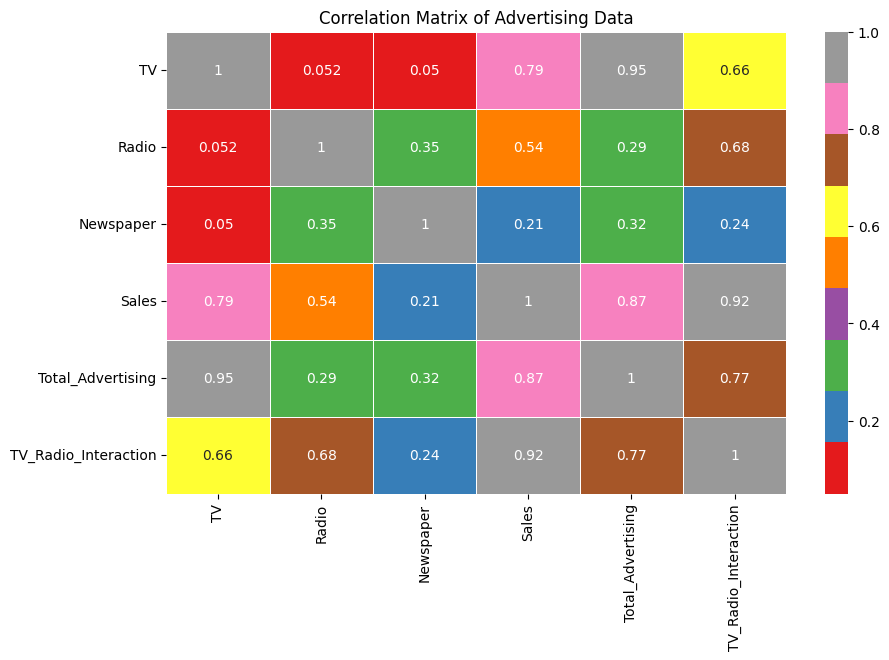

In [96]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Set1', linewidths=0.5)
plt.title('Correlation Matrix of Advertising Data')
plt.show()

In [97]:
!pip install --upgrade scikit-learn xgboost

In [98]:
from IPython import get_ipython
from IPython.display import display
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Import xgboost after upgrading
from xgboost import XGBRegressor
import joblib

# remove warnings
import warnings
warnings.filterwarnings('ignore')
# %%
print('Successfully Load Libraries')

Successfully Load Libraries


In [99]:
X = df.drop("Sales", axis=1)
y = df["Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
preprocessor = Pipeline(steps=[
    ("scaler", StandardScaler())  # Normalize features
])

# Define models and their hyperparameter grids
models = {
    "linear_regression": (LinearRegression(), {}),
    "ridge_regression": (Ridge(), {"ridge_regression__alpha": [0.1, 1.0, 10.0]}),
    "lasso_regression": (Lasso(), {"lasso_regression__alpha": [0.1, 1.0, 10.0]}),
    "decision_tree": (DecisionTreeRegressor(random_state=42), {"decision_tree__max_depth": [5, 10, 20]}),
    "random_forest": (RandomForestRegressor(random_state=42), {"random_forest__n_estimators": [50, 100], "random_forest__max_depth": [10, 20]}),
    "gradient_boosting": (GradientBoostingRegressor(random_state=42), {"gradient_boosting__n_estimators": [50, 100], "gradient_boosting__learning_rate": [0.1, 0.2]}),
     "support_vector_regression": (SVR(), {"support_vector_regression__C": [0.1, 1.0], "support_vector_regression__kernel": ["linear", "rbf"]}),
    "k_nearest_neighbors": (KNeighborsRegressor(), {"k_nearest_neighbors__n_neighbors": [3, 5, 7]}),

}

# Create a pipeline for each model and perform hyperparameter tuning
results = {}

for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        (model_name, model)
    ])

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
    grid_search.fit(X_train, y_train)
     # Evaluate the model
    y_pred = grid_search.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        "Best Parameters": grid_search.best_params_,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

# Sort the results by RMSE in ascending order
sorted_results = sorted(results.items(), key=lambda x: x[1]["RMSE"])


Training linear_regression...
Training ridge_regression...
Training lasso_regression...
Training decision_tree...
Training random_forest...
Training gradient_boosting...
Training support_vector_regression...
Training k_nearest_neighbors...


In [100]:
print("\nModel Evaluation Results (Sorted by RMSE in Ascending Order):")
for model_name, result in sorted_results:
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['Best Parameters']}")
    print(f"  MAE: {result['MAE']}")
    print(f"  MSE: {result['MSE']}")
    print(f"  RMSE: {result['RMSE']}")
    print(f"  R²: {result['R²']}")
    print()

# Display the best model with all metrics
best_model_name = sorted_results[0][0]
best_model_result = sorted_results[0][1]
print("\nBest Model:")
print(f"{best_model_name}:")
print(f"  Best Parameters: {best_model_result['Best Parameters']}")
print(f"  MAE: {best_model_result['MAE']}")
print(f"  MSE: {best_model_result['MSE']}")
print(f"  RMSE: {best_model_result['RMSE']}")
print(f"  R²: {best_model_result['R²']}")


Model Evaluation Results (Sorted by RMSE in Ascending Order):
gradient_boosting:
  Best Parameters: {'gradient_boosting__learning_rate': 0.2, 'gradient_boosting__n_estimators': 100}
  MAE: 0.07008569909928528
  MSE: 0.007286678059980148
  RMSE: 0.08536204109544328
  R²: 0.98508613721636

random_forest:
  Best Parameters: {'random_forest__max_depth': 20, 'random_forest__n_estimators': 100}
  MAE: 0.06874382499999968
  MSE: 0.008146557820174986
  RMSE: 0.0902582839421124
  R²: 0.9833261954914185

decision_tree:
  Best Parameters: {'decision_tree__max_depth': 10}
  MAE: 0.07736250000000001
  MSE: 0.009512857250000001
  RMSE: 0.09753387744778734
  R²: 0.9805297494222983

support_vector_regression:
  Best Parameters: {'support_vector_regression__C': 1.0, 'support_vector_regression__kernel': 'rbf'}
  MAE: 0.0963148107901236
  MSE: 0.018795168681395445
  RMSE: 0.13709547286980503
  R²: 0.9615313638941717

linear_regression:
  Best Parameters: {}
  MAE: 0.14623402956831127
  MSE: 0.0304684126

In [101]:
# Evaluate the best model on the training set
y_train_pred = grid_search.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate the best model on the test set
y_test_pred = grid_search.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print("Training Set Evaluation:")
print(f"  MAE: {train_mae}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")
print(f"  R²: {train_r2}")
print("\nTest Set Evaluation:")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R²: {test_r2}")

print('\n🎯 Check Training & Testing Evaluation Metrics for Model Overfitting OR Underfitting')

Training Set Evaluation:
  MAE: 0.074814135021097
  MSE: 0.014855816617440218
  RMSE: 0.12188443960342198
  R²: 0.9703701724666971

Test Set Evaluation:
  MAE: 0.12443916666666666
  MSE: 0.03523684008333335
  RMSE: 0.18771478386992685
  R²: 0.9278797013390584

🎯 Check Training & Testing Evaluation Metrics for Model Overfitting OR Underfitting


In [102]:
import os


# Create the directory if it doesn't exist
os.makedirs("/kaggle/working/", exist_ok=True)

# Save the best model using joblib
best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    (best_model_name, models[best_model_name][0])
])
best_pipeline.fit(X_train, y_train)

# Define the file path for saving the model
model_path = f"/kaggle/working/best_model_{best_model_name}.pkl"
joblib.dump(best_pipeline, model_path)
print(f"\nBest Model Saved: {model_path}")



Best Model Saved: /kaggle/working/best_model_gradient_boosting.pkl


In [103]:
# Save the best model using joblib
best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    (best_model_name, models[best_model_name][0])
])
best_pipeline.fit(X_train, y_train)

# Define the file path for saving the model
model_path = f"/kaggle/working/best_model_{best_model_name}.pkl"
joblib.dump(best_pipeline, model_path)
print(f"\nBest Model Saved: {model_path}")

# Load the saved model and make predictions
loaded_model = joblib.load(model_path)
y_pred_loaded = loaded_model.predict(X_test)

# Evaluate the loaded model
mae_loaded = mean_absolute_error(y_test, y_pred_loaded)
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
rmse_loaded = np.sqrt(mse_loaded)
r2_loaded = r2_score(y_test, y_pred_loaded)
# Display evaluation metrics
print("\nEvaluation Metrics for Loaded Model:")
print(f"  MAE: {mae_loaded}")
print(f"  MSE: {mse_loaded}")
print(f"  RMSE: {rmse_loaded}")
print(f"  R²: {r2_loaded}")


Best Model Saved: /kaggle/working/best_model_gradient_boosting.pkl

Evaluation Metrics for Loaded Model:
  MAE: 0.06532135165738333
  MSE: 0.006925410191760836
  RMSE: 0.08321904945239904
  R²: 0.9858255550100941


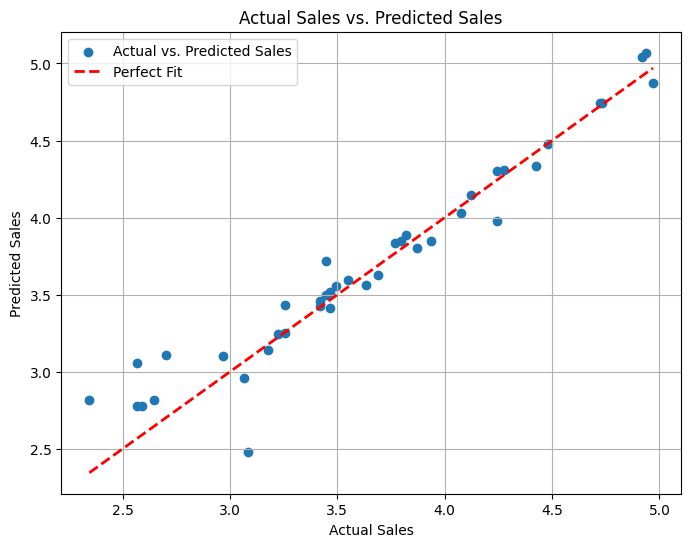

In [104]:
# Visualize the model's predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Actual vs. Predicted Sales')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Fit')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual Sales vs. Predicted Sales")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()